<a href="https://colab.research.google.com/github/vinayshanbhag/frequency_offset_measurements_in_time_domain/blob/main/frequency_offset_measurements_in_time_domain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
Fractional frequency offsets between a GPS disciplined oscillator and an ovenized crystal oscillator can be accurately measured using a high precision frequency counter. In this notebook we explore statistically estimating the same by sampling phase differences in time domain using an oscilloscope.

The GPS reference (10Mhz sinusoid) is connected to channel1 on the scope (Siglent SDS1202X-E). The OCXO reference (10Mhz Isotemp sinusoid) is connected to channel2. The scope is connected (via USB/TCP) to the computer.

Due to slight differences in frequency the OCXO waveform slowly drifts in phase with respect to the GPS reference. This phase difference data is sampled at regular intervals (~2Hz) and the data captured over time in a csv file. The csv file contains a timestamp for the measurement and the phase difference measured at that time by the oscilloscope. Script for capturing data via SCPI is [here](https://github.com/vinayshanbhag/frequency_offsets_in_time_domain/blob/main/ocxo_phase.py). Sample data captured using this script is [here](https://github.com/vinayshanbhag/frequency_offset_measurements_in_time_domain/blob/main/2023_10_01T13_16_30_565266_ocxo_phase.csv).

In [196]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
!pip install allantools
import allantools

In [197]:
def elapsed_time(x):
  """ Convert timedelta to duration in seconds
  """
  if x==pd.NaT:return pd.NaT
  return (x.components.days*86400 + x.components.hours*3600 + x.components.minutes*60 + x.components.seconds + x.components.milliseconds/1000 + x.components.microseconds/1_000_000 + x.components.nanoseconds/1_000_000_000)

Read the csv file and compute the diff in time and phase. i.e. Elapsed time between 2 consecutive readings and change in phase in that same period.

We can estimate the frequency difference as-

$\Delta f = \frac{\Delta\phi}{360 \times \Delta t} Hz$

where,

$\Delta f$ is the frequency difference between the two signals

$\Delta \phi$ is the phase difference between two consecutive samples

$\Delta t$ is the time difference between two consecutive samples


Averaging this value over time, gives an estimate of the difference between the OCXO and the reference.


In [198]:
df = pd.read_csv("/content/2023_10_01T13_16_30_565266_ocxo_phase.csv")
df['timestamp'] = df['timestamp'].astype(np.datetime64)

In [199]:
df['delta_t'] = df.timestamp.diff()
df['delta_phi'] = df.measured_phase_diff.diff()
df['delta_phi'] = df['delta_phi'].apply(lambda x: (x+180)%360 - 180)
df.dropna(inplace=True)
df['delta_t'] = df['delta_t'].apply(elapsed_time)
df['freq_err_ppb'] = df.apply(lambda x: x['delta_phi']*100/(360*x['delta_t']), axis=1)

mean error (54781 samples) : 0.004050Hz
last 100-samples mean error: 0.001709Hz


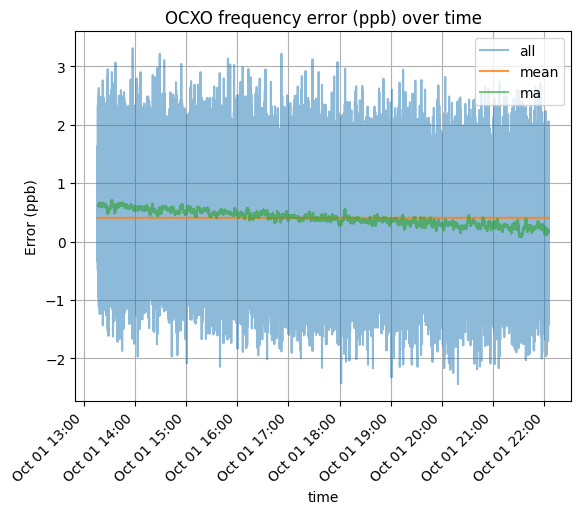

In [200]:
formatter = mdates.DateFormatter('%b %d %H:%M')

plt.plot(df.timestamp, df.freq_err_ppb,alpha=0.5,label="all")
plt.plot(df.timestamp, np.ones(len(df))*df.freq_err_ppb.mean(),alpha=0.8,label="mean")
plt.plot(df.timestamp, np.ones(len(df))*df.freq_err_ppb.rolling(window=100).mean(),alpha=0.6,label="ma")
plt.grid(True)
plt.legend(loc="upper right")
ax = plt.gca()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
xticks = ax.get_xticks()
ax.set_xticks(xticks)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation = 45, ha="right");
print(f"mean error ({len(df)} samples) : {df.freq_err_ppb.mean()/100:0.6f}Hz")
print(f"last 100-samples mean error: {df.freq_err_ppb.rolling(window=100).mean().values[-1]/100:0.6f}Hz")
plt.title("OCXO frequency error (ppb) over time");
plt.xlabel("time");
plt.ylabel("Error (ppb)");

Capturing this data over several hours or days, we can plot the Allan deviation $\sigma(\tau)$ as a function of averaging times $\tau$. Initially, the deviation falls as averaging time increases. However, over long periods of time the OCXO frequency has a slight drift, hence the deviation rises again as averaging time is increased.  

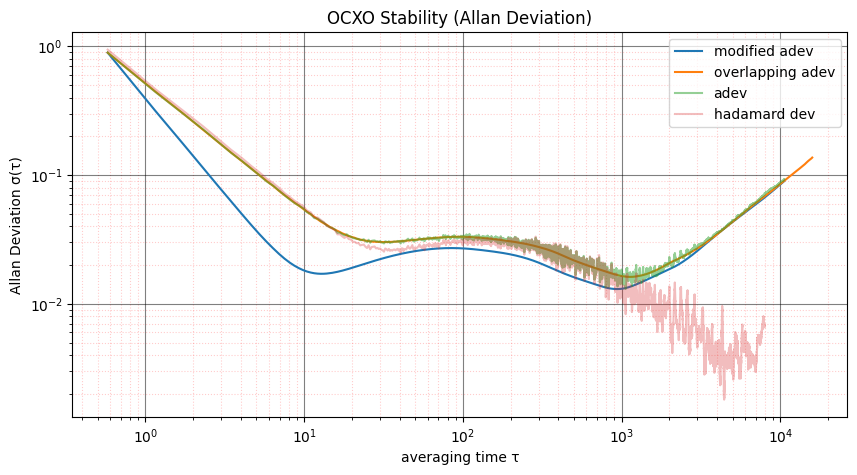

In [201]:
data = df.freq_err_ppb.values #np.random.randn(100)
data_type='freq'

rate = 1/df.delta_t.mean()
taus = 'all'
taus_mdv, mdv, mdve, ns_mdv     = allantools.mdev( data, data_type=data_type, rate=rate, taus=taus)
taus_oadv, oadv, oadve, ns_oadv = allantools.oadev(data, data_type=data_type, rate=rate, taus=taus)
taus_adv, adv, adve, ns_adv     = allantools.adev( data, data_type=data_type, rate=rate, taus=taus)
taus_hdv, hdv, hdve, ns_hdv     = allantools.hdev( data, data_type=data_type, rate=rate, taus=taus)

plt.figure(figsize=(10,5))
plt.plot(taus_mdv,mdv, label="modified adev")
plt.plot(taus_oadv,oadv, label="overlapping adev")
plt.plot(taus_adv,adv, label="adev", alpha=0.5)
plt.plot(taus_hdv,hdv, label="hadamard dev", alpha=0.3)

plt.legend(loc="upper right")
plt.yscale('log')
plt.xscale('log')
plt.grid(visible=True, which='major', color='k', linestyle='-', alpha=0.5)
plt.grid(visible=True, which='minor', color='r', linestyle=':', alpha=0.2)
plt.minorticks_on()
plt.title("OCXO Stability (Allan Deviation)");
plt.xlabel("averaging time τ");
plt.ylabel("Allan Deviation σ(τ)");

In [202]:
df.timestamp.dt.strftime("%m/%d %H:%M")

1        10/01 13:16
2        10/01 13:16
3        10/01 13:16
4        10/01 13:16
5        10/01 13:16
            ...     
54777    10/01 22:05
54778    10/01 22:05
54779    10/01 22:05
54780    10/01 22:05
54781    10/01 22:05
Name: timestamp, Length: 54781, dtype: object